# Ground-roll attenuation model with attention

This notebook reproduces model and model training and evaluation pipelines according to the paper [Attention-based neural network for improved ground-roll
attenuation in land seismic surveys]().

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)

## Dataset

Dataset consists of a 50 raw field shot gathers before and after ground-roll attenuation processing according to industrial standatrd. Seismic traces have 6s lengths and 2ms sample interval. Dataset is split into train and validation parts. Train parts contains 19 shot gathers.

Required imports:

In [64]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import segyio
from tqdm import tqdm

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, V

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import FieldMetrics
from seismicpro.src.file_utils import write_segy_file
from seismicpro.src.seismic_batch import FILE_DEPENDEND_COLUMNS

from unet import u_net, conv_block

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


Index and merge datasets of input and target traces:

In [56]:
path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers='all', path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,SourceX,SourceMeasurementUnit,CDP_TRACE,Correlated,LowCutSlope,DayOfYear,GapSize,GroupY,SourceEnergyDirectionMantissa,GeophoneGroupNumberLastTraceOrigField,...,ReceiverGroupElevation,OverTravel,ElevationScalar,SourceEnergyDirectionExponent,GeophoneGroupNumberRoll1,TotalStaticApplied,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,,,,,,,,...,,,,,,,raw,raw,lift,lift
FieldRecord,,,,,,,,,,,,,,,,,,,,,
111906,499287,0,1,0,0,54,0,6639788,0,0,...,37,0,0,0,0,0,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,499287,0,2,0,0,54,0,6639788,0,0,...,35,0,0,0,0,0,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,499287,0,3,0,0,54,0,6639788,0,0,...,37,0,0,0,0,0,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,499287,0,4,0,0,54,0,6639788,0,0,...,35,0,0,0,0,0,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,499287,0,5,0,0,54,0,6639788,0,0,...,37,0,0,0,0,0,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 19 field records for model training:

In [82]:
tindex = TraceIndex(index.create_subset(index.indices[:19]))
train_set = Dataset(tindex, SeismicBatch)

Show relative positions of train and test shot gathers:

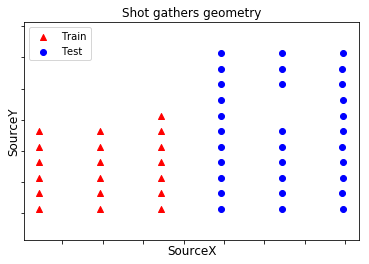

In [380]:
train_shots = train_index.get_df()[['SourceX', 'SourceY']].drop_duplicates()
test_shots = test_index.get_df()[['SourceX', 'SourceY']].drop_duplicates()
plt.scatter(*train_shots.values.T, marker="^", c='r', label='Train')
plt.scatter(*test_shots.values.T, c='b', label='Test')
plt.title('Shot gathers geometry')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.legend()
plt.show()

Sample of raw and target shot gather form train dataset. Here and in each seismic plot below
X-axis represents trace number in offset sorting, Y-axis counts time samples. 

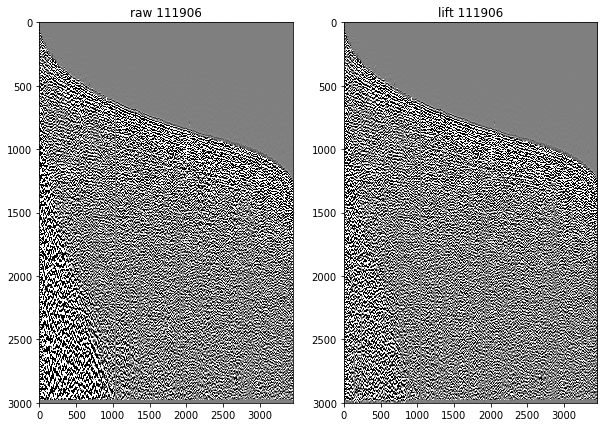

In [365]:
(SeismicDataset(train_index).next_batch(1)
 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
 .seismic_plot(('raw', 'lift'), index.indices[0], figsize=(10, 7),
               vmax=0.1, vmin=-0.1, cmap='gray'))

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask. In the next cell we set model and loss function configurations:

In [4]:
config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    trace_raw = tf.placeholder('float', shape=(None, 3000, 1), name='trace_in')
    targets = tf.placeholder('float', shape=(None, 3000, 1), name='target')
    alpha = tf.placeholder('float', name='alpha')
    beta = tf.placeholder('float', name='beta')
    learning_rate = tf.placeholder('float', name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    #Attention branch
    with tf.variable_scope("attention_scope"):
        out_attention = u_net(trace_raw, depth=3, filters=8, kernel_size=3,
                              activation='elu', is_training=is_training)
        out_attention = conv_block(out_attention, 'ca', filters=1, kernel_size=3,
                                   activation='sigmoid')
        print('attention', out_attention.get_shape())

    attention_sum = tf.reduce_sum(out_attention, axis=1, keepdims=True)
    print('attention_sum', attention_sum.get_shape())

    #Define a domain for sigmoid function
    sigm_x = tf.fill(tf.shape(out_attention), 0.0)
    arange = tf.range(0, tf.cast(tf.shape(sigm_x)[1], 'float'), dtype='float')
    arange = tf.expand_dims(arange, axis=-1)
    sigm_x = sigm_x - arange + attention_sum
    print('sigm_x', sigm_x.get_shape())
    
    #Apply sigmoid function to the above obtained domain
    attention_sigmoid = tf.sigmoid(sigm_x)
    print('attention_sigmoid', attention_sigmoid.get_shape())
    
    #Main branch
    with tf.variable_scope("main_scope"):
        out_main = u_net(trace_raw, depth=5, filters=16, kernel_size=7,
                         activation='elu', is_training=is_training)
        out_main = conv_block(out_main, 'c', filters=1, kernel_size=3)
    print('out_main', out_main.get_shape())
    
    #Get a model output that is a superposition of raw input and main branches
    #according to attention mask
    predictions = trace_raw * attention_sigmoid + out_main * (1 - attention_sigmoid)

    #Loss compontents
    noise_loss = tf.losses.absolute_difference(targets, predictions)
    cone_loss = alpha * tf.reduce_mean(1 - attention_sigmoid)
    sigm_loss = beta * tf.losses.absolute_difference(attention_sigmoid, out_attention)
    
    #Loss for attention mask and denoising
    total_loss = noise_loss + sigm_loss + cone_loss

    #Weights for cone noise loss
    weights = (1 - attention_sigmoid) / tf.reduce_sum(1 - attention_sigmoid)
    print('weights', weights.get_shape())

    #Denoising loss within ground-roll cone
    cone_noise_loss = tf.losses.absolute_difference(targets, predictions,
                                                    reduction=tf.losses.Reduction.SUM,
                                                    weights=weights)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    main_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='main_scope')
    attention_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='attention_scope')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step_attention = optimizer.minimize(total_loss, var_list=attention_vars)
        step_main = optimizer.minimize(total_loss, var_list=main_vars)
        step_cone = optimizer.minimize(cone_noise_loss, var_list=main_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
#     saver.restore(sess, './demo_attention_model_H.ckpt')

input (?, 3000, 1)
conv_block_0 (?, 3000, 8)
pool_0 (?, 1500, 8)
conv_block_1 (?, 1500, 16)
pool_1 (?, 750, 16)
conv_block_2 (?, 750, 32)
pool_2 (?, 375, 32)
bottom_conv_block_3 (?, 375, 64)
up_2 (?, 750, 64)
concat_3 (?, 750, 96)
up_conv_block_3 (?, 750, 32)
up_1 (?, 1500, 32)
concat_2 (?, 1500, 48)
up_conv_block_2 (?, 1500, 16)
up_0 (?, 3000, 16)
concat_1 (?, 3000, 24)
up_conv_block_1 (?, 3000, 8)
attention (?, 3000, 1)
attention_sum (?, 1, 1)
sigm_x (?, 3000, 1)
attention_sigmoid (?, 3000, 1)
input (?, 3000, 1)
conv_block_0 (?, 3000, 16)
pool_0 (?, 1500, 16)
conv_block_1 (?, 1500, 32)
pool_1 (?, 750, 32)
conv_block_2 (?, 750, 64)
pool_2 (?, 375, 64)
conv_block_3 (?, 375, 128)
pool_3 (?, 188, 128)
conv_block_4 (?, 188, 256)
pool_4 (?, 94, 256)
bottom_conv_block_5 (?, 94, 512)
up_4 (?, 188, 512)
concat_5 (?, 188, 768)
up_conv_block_5 (?, 188, 256)
up_3 (?, ?, 256)
concat_4 (?, 375, 384)
up_conv_block_4 (?, 375, 128)
up_2 (?, 750, 128)
concat_3 (?, 750, 192)
up_conv_block_3 (?, 750, 64

## Training

Training pipeline actions:

In [5]:
train_pipeline = (Pipeline().load(components=('raw', 'lift'), fmt='segy',
                                  tslice=np.arange(3000)))
train_pipeline = train_pipeline << train_set

Adaptive training scheme:

In [6]:
def sheduler(i):
    if i < 500:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.01,
                              learning_rate: 0.001}}
    elif i < 750:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.05,
                              learning_rate: 0.001}}
    elif i < 1000:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.1,
                              learning_rate: 0.001}}
    elif i < 1750:
        return {'fetches': [cone_noise_loss, step_cone],
                'feed_dict': {learning_rate: 0.0001}}
    elif i < 2250:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.1,
                              learning_rate: 0.001}}
    else:
        return {'fetches': [cone_noise_loss, step_cone],
                'feed_dict': {learning_rate: 0.0001}}

Run model training:

In [7]:
loss_history = []
for i in tqdm(range(3000)):
    batch = train_pipeline.next_batch(batch_size=64, drop_last=True,
                                      n_enochs=None, shuffle=True)

    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    
    act = sheduler(i)

    feed_dict = {trace_raw: x, targets: y, is_training: True,}
    feed_dict.update(act['feed_dict'])
    
    res = sess.run(act['fetches'], feed_dict=feed_dict)

    loss_history.append(res)

100%|██████████| 3000/3000 [15:59<00:00,  3.21it/s]


Loss on each stage:

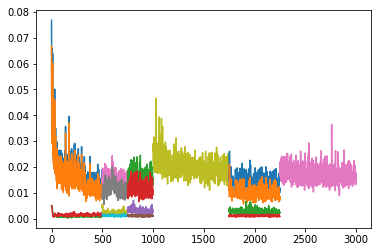

In [38]:
t = [0, 500, 750, 1000, 1750, 2250, 3000]
for i in range(len(t) - 1):
    x = np.arange(t[i], t[i+1])
    plt.plot(x, np.array(loss_history[t[i]:t[i+1]]))
plt.show()

Save the model:

In [95]:
# saver.save(sess, '/notebooks/egor/gazprom-neft/SeismicPro/models/Ground-roll_attenuation/Attention_model/tf_attention_model.ckpt')

### Model estimation

For model evaluation we first consider a sample seismogram outside of train set and compare it with
input and trarget seismograms.

Inference on a sample seismogram:

In [83]:
i = 29
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000)))

    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)

    res = sess.run([predictions, out_attention, attention_sigmoid],
                   feed_dict={trace_raw: x, is_training: False})

    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)

Arrange results

In [84]:
out = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out_att = np.squeeze(np.concatenate([t[1] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[2] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))

### Visual estimation

Show raw seismogram, model attention mask, model output and difference between model output and raw input:

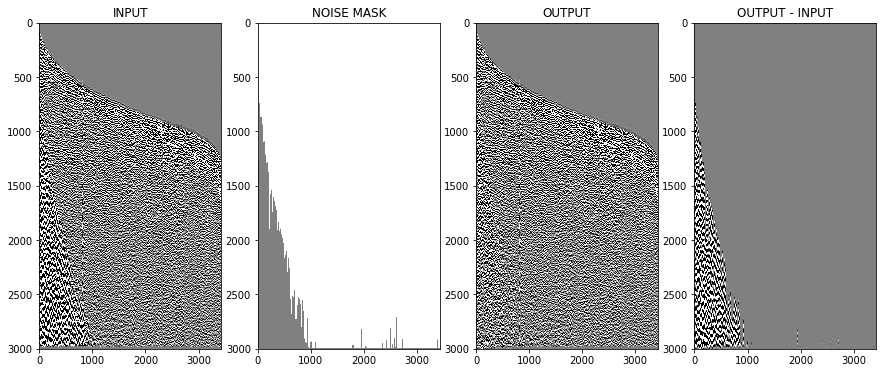

In [85]:
cv = 0.1
seismic_plot([raw, att_sigm, out, out - raw], names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Show model output, traget seismogram difference between them:

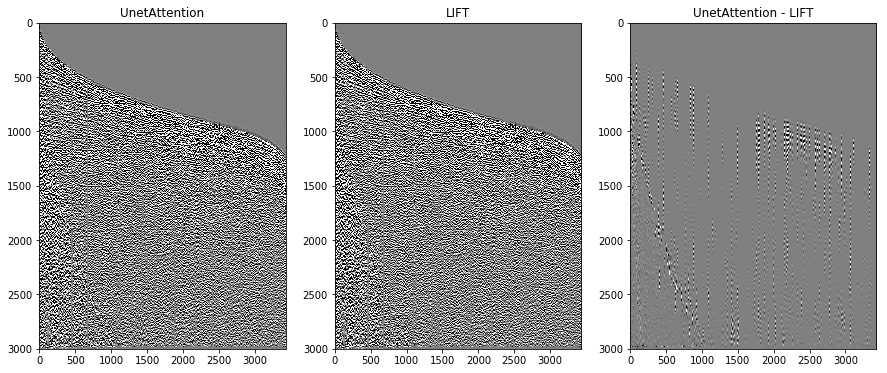

In [88]:
seismic_plot([out, lift, out - lift],
             figsize=(15, 6), names=['UnetAttention', 'LIFT', 'UnetAttention - LIFT'],
             cmap='gray', vmin=-cv, vmax=cv)

### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

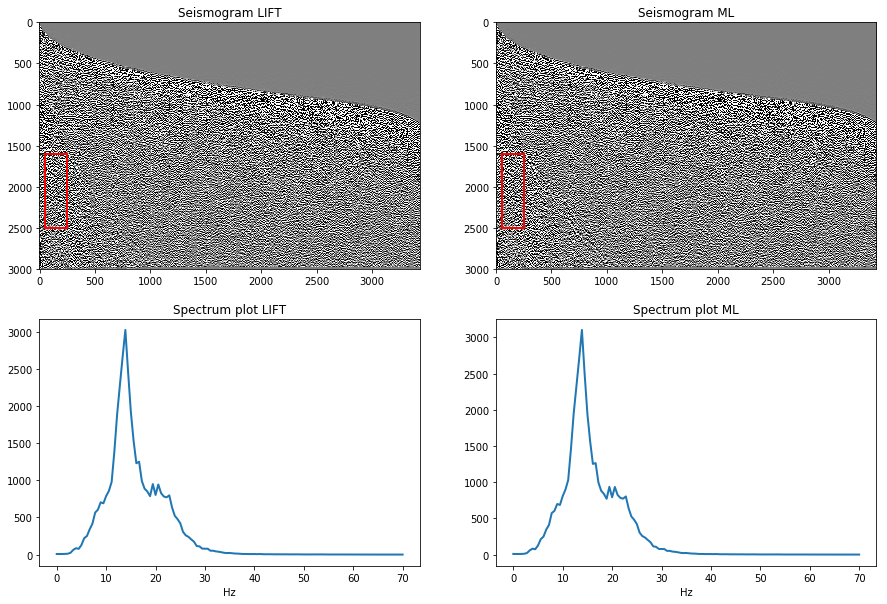

In [30]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(50, 250), slice(1600, 2500)),
                    rate=0.002, max_freq=70,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

### MAE metrics

Estimate MAE between model output and target seismogram:

In [89]:
mtr = FieldMetrics(lift, out)
print('MAE:', mtr.mae())

MAE: 0.0052776546


### Ground-roll cone approximation

Show ground-roll cone approximation given by thresholded difference of input and target seismograms and given by attention mask:

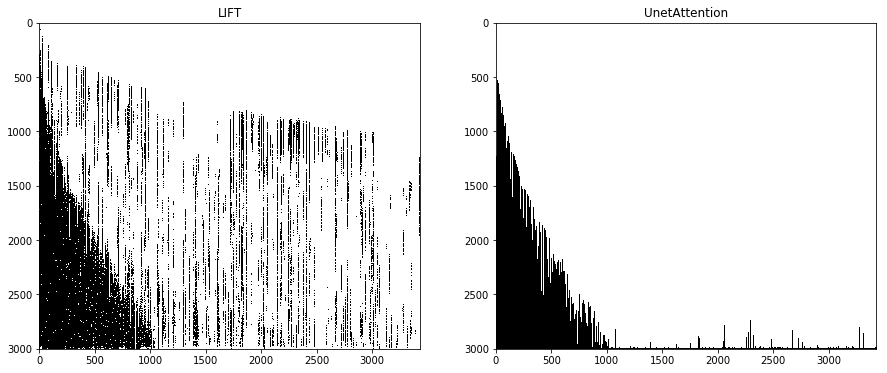

In [92]:
seismic_plot([abs(lift - raw) < .007, att_sigm > 0.5],
             names=['LIFT', 'UnetAttention'],
             figsize=(15, 6), vmin=0, vmax=1, cmap='gray'
            )

Compute IoU for binary masks obtained:

In [94]:
FieldMetrics(abs(lift - raw) > 0.007, att_sigm < 0.5).iou()

0.6274005518770621

## Mertics on whole dataset

Run trace-by-trace inference on whole dataset:

In [58]:
batch_size = 2000
run_set = Dataset(TraceIndex(index), SeismicBatch)

def dump_single_segy(data, df, samples, path):
    """Dump data to segy file."""
    df.reset_index(drop=True, inplace=True)
    headers = list(set(df.columns.levels[0]) - set(FILE_DEPENDEND_COLUMNS))
    segy_headers = [h for h in headers if hasattr(segyio.TraceField, h)]
    df = df[segy_headers]
    df.columns = df.columns.droplevel(1)
    write_segy_file(data, df, samples, path)

for k in range(1 + len(run_set) // batch_size):
    batch = (run_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000)))

    x = np.expand_dims(np.vstack(batch.raw), -1)

    res = sess.run(predictions,
                   feed_dict={trace_raw: x, is_training: False})
    
    df = batch.index.get_df(reset=False)
    samples = batch.meta['raw']['samples']
    dump_single_segy(res, df, samples, './tmp/' + str(k) + '.sgy')

Merge batches into single file:

In [61]:
merge_segy_files(output_path='./tmp/merged.sgy', extra_headers='all',
                 path=os.path.join('./tmp/', '*.sgy'))

100%|██████████| 88/88 [00:42<00:00,  2.12it/s]


Join index of processed traces with current index:

In [62]:
path_unet = './tmp/merged.sgy'
index = index.merge(FieldIndex(name='unet', path=path_unet))

Define pipeline for metrics calculation:

In [68]:
def get_pos(batch, *args):
    sx = batch.trace_headers('SourceX', flatten=True)[0]
    sy = batch.trace_headers('SourceY', flatten=True)[0]
    ffid = batch.trace_headers('FieldRecord', flatten=True)[0]
    return sx, sy, ffid

def eval_mt(batch, *args):
    mt = FieldMetrics(batch.lift[0], batch.unet[0], batch.raw[0])
    snr_lift = mt.signaltonoise2(src_clean='targets', src_noised='raw')
    snr_unet = mt.signaltonoise2(src_clean='predictions', src_noised='raw')
    return mt.mae(), snr_lift, snr_unet
    

metr_pipeline = (Pipeline()
                 .init_variable('mt', [])
                 .init_variable('pos', [])
                 .load(components=('unet', 'lift', 'raw'), fmt='segy', tslice=np.arange(3000))
                 .call(get_pos, save_to=V('pos', mode='a'))
                 .call(eval_mt, save_to=V('mt', mode='a')))

Run pipeline

In [70]:
metr_pipeline = metr_pipeline << Dataset(index, SeismicBatch)
metr_pipeline = metr_pipeline.run(batch_size=1, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

Arrange results

In [73]:
pos = np.vstack(metr_pipeline.get_variable('pos'))
mt = np.vstack(metr_pipeline.get_variable('mt'))
mae, snr_lift, snr_unet = mt[:, 0], mt[:, 1], mt[:, 2]

Plot MAE metrics over shot gathers:

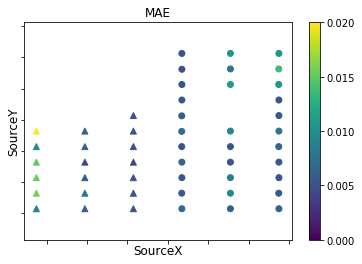

Mean train value = 0.008
Mean test value = 0.007


In [79]:
vmin = 0
vmax = 0.02
plt.scatter(*pos[:19, :2].T, c=mae[:19], marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=mae[19:], vmin=vmin, vmax=vmax)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('MAE')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.tick_params(axis='both', which='both',
                labelbottom=False, labeltop=False, labelleft=False)
plt.show()

print('Mean train value = {:.3f}'.format(np.mean(mae[:19])))
print('Mean test value = {:.3f}'.format(np.mean(mae[19:])))

Show SNR ratio for LIFT traces:

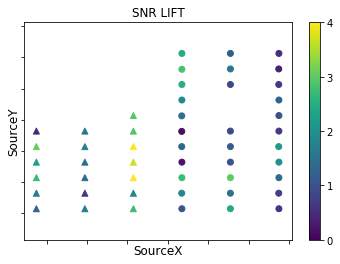

Mean train value = 2.239
Mean test value = 1.499


In [80]:
vmin = 0
vmax = 4
plt.scatter(*pos[:19, :2].T, c=snr_lift[:19], marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=snr_lift[19:], vmin=vmin, vmax=vmax)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('SNR LIFT')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.tick_params(axis='both', which='both',
                labelbottom=False, labeltop=False, labelleft=False)
plt.show()

print('Mean train value = {:.3f}'.format(np.mean(snr_lift[:19])))
print('Mean test value = {:.3f}'.format(np.mean(snr_lift[19:])))

Show SNR ratio for Unet model:

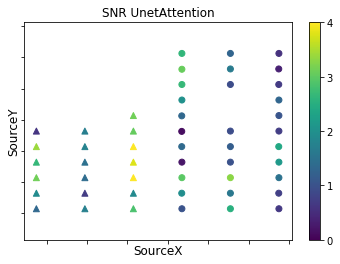

Mean train value = 2.401
Mean test value = 1.591


In [81]:
vmin = 0
vmax = 4
plt.scatter(*pos[:19, :2].T, c=snr_unet[:19], marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=snr_unet[19:], vmin=vmin, vmax=vmax)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('SNR UnetAttention')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.tick_params(axis='both', which='both',
                labelbottom=False, labeltop=False, labelleft=False)
plt.show()

print('Mean train value = {:.3f}'.format(np.mean(snr_unet[:19])))
print('Mean test value = {:.3f}'.format(np.mean(snr_unet[19:])))

Done! We do not provide here pipelines for model validation around well since it is related to external software.

You are welcome to explore [https://github.com/gazprom-neft](https://github.com/gazprom-neft) repository for more models and seismic processing tools.